In [3]:
from collections import defaultdict
import numpy as np
import pdb
import dill
# from sklearn.datasets.samples_generator import make_blobs
import random
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score
import seaborn as sn

ModuleNotFoundError: No module named 'numpy'

In [7]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [8]:
lorents = Lorentz()
data, _, _ = Lorentz().generate(0.1, 100000)
data = (data - data.min()) / (data.max() - data.min())

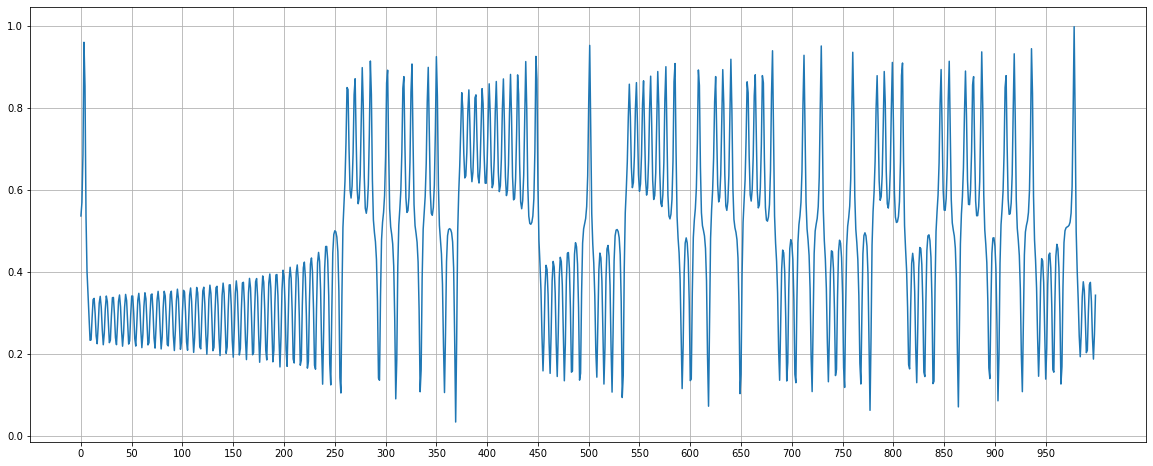

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(data[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

In [1]:
from statistics import mean
# import app
# from .. import *
import sys
sys.path.append("..")
from wishart.wishart_lib import Wishart
from motifs.motifs import GenerateAllMotifs
size = len(data)
train_data = data[:int(size * 0.7)]
test_data = data[int(size * 0.7):]

NameError: name 'data' is not defined

In [14]:
def get_val_for_pattern_and_pos(data: np.array, pattern: list, pos: int, bad):
    val = []
    sum = 0
    for i in range(len(pattern) - 1, -1, -1):
      sum += pattern[i]
      val.append(data[pos - sum])
      if bad[pos - sum]:
          return np.array([])
    val = val[::-1]
    return np.array(val)

def get_val_for_motifs(data: np.array, motif: list, bad):
    val = []
    for i in motif:
        val.append(data[i])
        if bad[i]:
            return np.array([])
    return np.array(val)


def mode(a):
    return max(set(a), key=a.count)

def is_predictable(a):
    return abs(mean(a) - mode(a)) / mode(a) <= 0.1

def get(a):
    return abs(mean(a) - mode(a)) / mode(a)

def base_prediction(data, h: int, L: int = 3, kmax: int = 10, eps: float = 5):
    t = len(data)
    prediction = data
    prediction = np.resize(prediction, t + h)
    bad = np.array([0 for i in range(t + h)])
    # print(prediction)
    for i in range(t):
        prediction[i] = data[i]
    possible_values = [[] for i in range(h)]
    d = []
    for i in range(h):
        for pattern, all_motifs  in GenerateAllMotifs(kmax, L, t + i - 1):
            val_for_pattern = get_val_for_pattern_and_pos(prediction, pattern, t + i, bad)
            # print(val_for_pattern)
            if len(val_for_pattern) == 0:
                continue
            start = val_for_pattern[0]
            val_for_pattern = val_for_pattern - [val_for_pattern[0]] * len(val_for_pattern)
          
            all_val = [get_val_for_motifs(prediction, motif, bad) for motif in all_motifs]
            all_val = [i - [i[0]] * len(i) for i in all_val if len(i)]
            centers = get_centers(all_val)

            for c in centers:
              if len(c) == 0:
                  continue
            #   print(c, val_for_pattern)
              dist = np.linalg.norm(c[:-1] + val_for_pattern)
            #   d.append(dist)
              if dist < eps:
                  
                  print(val_for_pattern)
                  print(c)
                  print(dist)
                #   print(start)
                  possible_values[i].append(c[-1] + start)
                
        # sorted(possible_values)mean
        # print("aa")
        # print(len(possible_values[i]))
        if len(possible_values[i]):
            # print(len(possible_values[i]),  mean(possible_values[i]))
            # print(get(possible_values[i]))
            prediction[t + i] = mean(possible_values[i])
        else:
            bad[t + i] = 1
        # print(prediction[t + i])
    # print(sorted(d)[len(d) // 2])
    return [prediction, bad]


# base_prediction(test_data[-40:], 5)


In [16]:
h = 10
print(len(train_data))
prediction, bad = base_prediction(train_data[-400:], h, L=3, eps=100)

# print(prediction[-h:])
plt.plot(list(train_data[-100:]), 'g', label='prediction')
print(prediction[-h:])
print(bad[-h:])
plt.figure(figsize=(18, 12))
plt.plot(prediction[-h:], 'r', label='prediction')
plt.plot(list(test_data[:h]), 'b', label='test')
plt.legend(loc='best')
# plt.scatter(list(range(0, h)), list(prediction[-h:]), s=50, c='r', label='prediction')
# # plt.plot(test_data, 'b', label='prediction')
plt.show()

70000


NameError: name 'GenerateAllMotifs' is not defined